In [1]:
from qulacs import QuantumState
from qulacs.gate import Identity, X, Y, Z #パウリ演算子
from qulacs.gate import H, S, Sdag, sqrtXdag, sqrtY, sqrtYdag # 1量子ビットClifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import QuantumCircuit
import matplotlib.pyplot as plt
import numpy as np

## 一番簡単なNoise Mitigationを実装してみる。

In [2]:
## 理想的な回路の構築
nqubits = 1
state = QuantumState(nqubits)
state.set_zero_state()
circuit  = QuantumCircuit(nqubits)
circuit.add_H_gate(0)
angle = np.pi/2.0
circuit.add_gate(RZ(0,angle))
circuit.add_H_gate(0)

circuit.update_quantum_state(state)

In [3]:
## 観測量の定義
from qulacs import Observable, QuantumState
Pauli_product = "Z 0"
observable = Observable(nqubits)
observable.add_operator(1.0,Pauli_product)

In [4]:
## 期待値の計算
ex_value = observable.get_expectation_value(state)
print(ex_value)

1.1102230246251565e-16


## サンプリングによる期待値の評価

In [5]:
from qulacs.gate import P0, P1
meas_ope = P0(0) #0番目の量子ビットに作用する|0>への射影演算子
meas_ope.update_quantum_state(state)

In [6]:
# 確率計算は`get_norm()`
prob_zero = state.get_squared_norm()
print(prob_zero)

0.4999999999999999


In [7]:
# 測定結果をサンプルして返す関数を定義する
import random
def sample(prob_zero):
    if random.random() < prob_zero:
        return 0
    else:
        return 1

## 干渉を見る

In [8]:
def interferometer(phase, num_sample):
    nqubits = 1
    state = QuantumState(nqubits)
    state.set_zero_state()

    circuit = QuantumCircuit(nqubits)
    circuit.add_H_gate(0)
    angle = phase
    circuit.add_gate(RZ(0, angle))
    circuit.add_H_gate(0)
    circuit.update_quantum_state(state)

    meas_ope = P0(0) # 0番目の量子ビットに作用する|0>への射影演算子
    meas_ope.update_quantum_state(state)

    prob_zero = state.get_squared_norm()

    mean_value = 0.0
    for i in range(num_sample):
        mean_value = mean_value + (1 - 2*sample(prob_zero))
    mean_value = mean_value / num_sample
    return  mean_value

In [9]:
result = []

for i in range(100):
    phase = i * np.pi / 100.0
    result.append(interferometer(phase, 100))

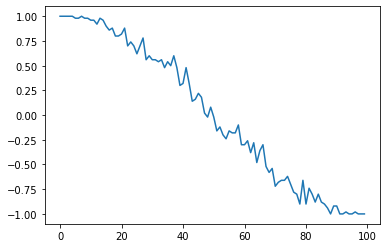

In [10]:
import matplotlib.pyplot as plt
plt.plot(result)

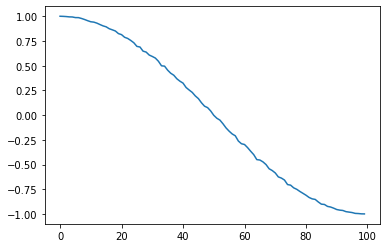

In [11]:
result = []
for i in range(100):
    phase = i * np.pi / 100.0
    result.append(interferometer(phase, 10000))

import matplotlib.pyplot as plt
plt.plot(result)

## ノイズの導入
量子回路におけるノイズを導入しよう。qulacsではノイズ（一般的なCPTP写像）の実装がなされている。あらかじめ定義されているノイズは、BitFlipNoise, DephasingNoise, IndepenedentXZNoise, DepolarizingNoise。

位相緩和、DephasingNoiseを入れてみよう。

In [12]:
from qulacs.gate import DephasingNoise

In [13]:
nqubits = 1
state = QuantumState(nqubits)
state.set_zero_state
H(0).update_quantum_state(state)
DephasingNoise(0, 0.5).update_quantum_state(state)
print(state.get_vector())

[0.70710678+0.j 0.70710678+0.j]


In [14]:
# 位相緩和が入った干渉をみてみる
def noisy_interferometer(phase, num_sample, dephasing_rate):
    nqubits = 1
    state = QuantumState(nqubits)

    mean_value = 0.0
    for i in range(num_sample):
        state.set_zero_state()
        circuit = QuantumCircuit(nqubits)
        H(0).update_quantum_state(state)
        RZ(0, phase).update_quantum_state(state)
        DephasingNoise(0, dephasing_rate).update_quantum_state(state)
        H(0).update_quantum_state(state)
        P0(0).update_quantum_state(state)

        prob_zero = state.get_squared_norm()
        mean_value = mean_value + (1 - 2*sample(prob_zero))
    mean_value = mean_value / num_sample
    return  mean_value

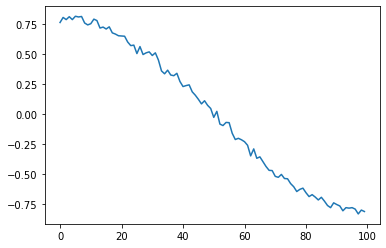

In [15]:
result = []
for i in range(100):
    phase = i * np.pi / 100.0
    result.append(noisy_interferometer(phase, 1000, 0.1))

plt.plot(result)

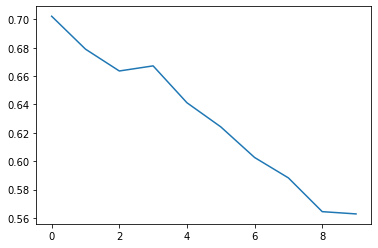

In [17]:
result = []
for i in range(10):
    result.append(noisy_interferometer(np.pi / 4.0 - 0.1, 10000, 0.05 + 0.01 * i))
plt.plot(result)

In [18]:
print(result)

[0.7022, 0.679, 0.6636, 0.6672, 0.6412, 0.6242, 0.6026, 0.5882, 0.5644, 0.5628]


## データをフィッティングしてノイズパラメータが0の時の期待値を外挿して求める

In [19]:
a, b = np.polyfit([0.05 + 0.01 * i for i in range(10)], result, 1)

In [20]:
print(a, b)

-1.6027878787878778 0.7818048484848481


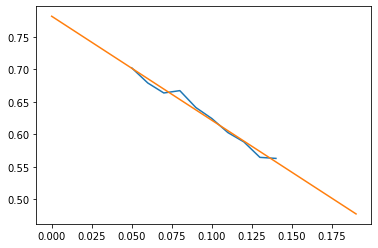

In [21]:
plt.plot([0.05 + 0.01 * i for i in range(10)], result)
x = np.arange(0, 0.2, 0.01)
y = a * x + b
plt.plot(x, y)

ノイズパラメータが0の時の期待値は、・・・。5%のノイズのあるサンプリング結果は、

In [22]:
noisy_interferometer(np.pi / 4.0 - 0.1, 10000, 0.05)

0.6942

In [23]:
# 理想的な結果は、
def ideal_interferometer(phase):
    nqubits = 1
    state = QuantumState(nqubits)
    state.set_zero_state()

    circuit = QuantumCircuit(nqubits)
    circuit.add_H_gate(0)
    angle = phase
    circuit.add_gate(RZ(0, angle))
    circuit.add_H_gate(0)
    circuit.update_quantum_state(state)

    Pauli_product = "Z 0"
    observable = Observable(nqubits)
    observable.add_operator(1.0, Pauli_product)
    ex_value = observable.get_expectation_value(state)
    return  ex_value

In [24]:
ideal_interferometer(np.pi / 4.0 - 0.1)

0.7741670784769461

## 指数関数によるフィッティング

In [29]:
def ideal_circuit():
    np.random.seed(0) #乱数のシードを固定する

    nqubits = 5
    depth = 5

    angles = [np.random.random() for i in range(nqubits*depth)]
    state = QuantumState(nqubits)
    state.set_zero_state

    circuit  = QuantumCircuit(nqubits)
    l=0
    for j in range(depth):
        for i in range(nqubits):
            circuit.add_H_gate(i)
            circuit.add_gate(RZ(i,angles[l]*np.pi))
            l=l+1;

        for i in range(nqubits-1):
            circuit.add_gate(CZ(i,i+1))

    for i in range(nqubits):
        circuit.add_H_gate(i)

    circuit.update_quantum_state(state)

    Pauli_product = "Z 0"
    observable = Observable(nqubits)
    observable.add_operator(1.0,Pauli_product)
    ex_value = observable.get_expectation_value(state)
    return  ex_value

In [30]:
ideal_circuit()

-0.04191960457711601

ノイズを含んだサンプリングバージョンを定義する

In [33]:
from qulacs.gate import DepolarizingNoise

def noisy_circuit(num_sample,depo_rate):
    nqubits = 5
    depth = 5
    np.random.seed(0) #乱数のシードを固定する
    angles = [np.random.random() for i in range(nqubits*depth)]
    state = QuantumState(nqubits)

    mean_value =0.0

    for k in range(num_sample):
        circuit  = QuantumCircuit(nqubits)
        state.set_zero_state()
        l=0
        for j in range(depth):
            for i in range(nqubits):
                H(i).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)

                RZ(i,angles[l]*np.pi).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)
                l=l+1

            for i in range(nqubits-1):
                CZ(i,i+1).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)
                DepolarizingNoise(i+1,depo_rate).update_quantum_state(state)

        for i in range(nqubits):
            H(i).update_quantum_state(state)

        P0(0).update_quantum_state(state)

        # prob_zero = state.get_norm()
        prob_zero = state.get_squared_norm()

        mean_value = mean_value +(1-2*sample(prob_zero))

    mean_value = mean_value/num_sample
    return  mean_value

In [34]:
noisy_circuit(1000, 0)

-0.024